### 📓 **Data Preprocessing Notebook – Real Dataset Setup**

This notebook handles the initial preparation and validation of the **real-world fire dataset (D-Fire)** for use in binary image classification tasks. Specifically, it performs the following steps:

- Defines the file paths to the raw D-Fire training images and labels stored in Google Drive  
- Imports the custom `FireClassificationDataset` class created in PyCharm  
- Applies torchvision image transforms (e.g., resizing and tensor conversion)  
- Instantiates the dataset and verifies that it loads images and labels correctly  
- Optionally previews sample images and labels to ensure correctness  

This notebook focuses exclusively on loading and verifying the **real dataset**. Synthetic datasets will be handled in a separate preprocessing notebook. This step is essential to confirm that the dataset pipeline functions correctly before proceeding to model training.


### 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is ready to run by:

- Mounting your Google Drive (where your token is stored)  
- Loading your GitHub token from Drive  
- Cloning the project repository into the Colab VM (fresh each time)  
- Navigating into the cloned repo  
- Setting Git credentials to enable committing changes if needed

> ⚠️ **Note**: This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔁 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 26 (delta 7), reused 20 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 9.12 KiB | 9.12 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/fire-detection-dissertation


### 🗂️ Step 1 – Define File Paths for Real Dataset

In this step, we define the absolute paths to the **training images** and **corresponding YOLO label files** from the real-world D-Fire dataset stored in Google Drive.

These paths will be passed into the custom `FireClassificationDataset` class so it can read and return each image and its binary label (fire vs no fire).

It's essential that:
- The image files are in `.jpg` format
- The label files have matching filenames but with `.txt` extensions (YOLO format)


In [2]:
# Define paths to D-Fire training images and label files in Google Drive
image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/images"
label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/labels"



### 🔧 Step 2 – Import Dataset Class and Define Image Transformations

In this step, we import the custom `FireClassificationDataset` class that was written and pushed to the GitHub repository using PyCharm.

We also define a set of **image preprocessing transformations** using `torchvision.transforms`. These will:
- Resize all images to `224x224` pixels to match the input size expected by ResNet-50
- Convert the images to PyTorch tensors
- Normalize pixel values to the `[0, 1]` range

These transforms are passed into the dataset class and applied **on-the-fly** during data loading.


In [3]:
from utils.fire_classification_dataset import FireClassificationDataset
from torchvision import transforms

# Define transforms to resize and convert images to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet
    transforms.ToTensor()           # Convert to [C, H, W] tensor in [0, 1] range
])



### 📦 Step 3 – Create the Dataset Object and Inspect a Sample

In this step, we instantiate the `FireClassificationDataset` using the image and label directories we defined earlier, along with the preprocessing transform pipeline.

This dataset object will allow us to:
- Access any individual sample using an index (e.g., `dataset[0]`)
- Automatically load the corresponding image and its binary label
- Apply resizing and tensor conversion on the fly

We then inspect the shape of the resulting image tensor and the label to confirm that:
- The image has 3 channels (RGB)
- The resolution has been resized correctly to `224 × 224`
- The label is correctly returned as a PyTorch tensor (`0` or `1`)


In [4]:
# Create the dataset object
dataset = FireClassificationDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=transform
)

# Load the first sample (image and label)
image, label = dataset[16000]

# Display tensor shape and label
print("Image shape:", image.shape)       # Expected: [3, 224, 224]
print("Label:", label.item())            # Expected: 0 or 1


Image shape: torch.Size([3, 224, 224])
Label: 0


### 🖼️ Step 4 – Visualise a Sample Image and Its Binary Label

Now that the dataset is loading image tensors and binary labels correctly, we visually inspect a sample image to confirm that:

- The image is being read and preprocessed correctly
- The orientation, colors, and scaling look natural
- The binary label (`0` = no fire, `1` = fire) makes visual sense

This visual check is helpful for debugging and verifying that the model will receive high-quality input during training. We'll use `matplotlib` to display the image and show its label in the title.


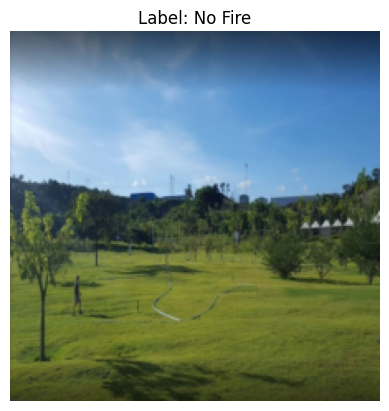

In [10]:
import matplotlib.pyplot as plt

# Choose a sample index to display
index = 11000
image, label = dataset[index]

# Permute image dimensions from [C, H, W] to [H, W, C] for visualization
image_np = image.permute(1, 2, 0)

# Plot the image
plt.imshow(image_np)
plt.title(f"Label: {'Fire' if label.item() == 1 else 'No Fire'}")
plt.axis('off')
plt.show()


In [11]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [12]:
# Step 1: Change directory to the cloned GitHub repo (if not already there)
%cd /content/fire-detection-dissertation

# Step 2: Stage the updated notebook
!git add notebooks/02_data_preprocessing.ipynb

# Step 3: Commit with a clear message
!git commit -m "Add data preprocessing notebook for real D-Fire dataset (image loading, label logic, visual checks)"

# Step 4: Push to GitHub
!git push


/content/fire-detection-dissertation
fatal: pathspec 'notebooks/02_data_preprocessing.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date
